# Overview

- Load .bit file
- Basic loopback program calibration
    - original code from demo
    - time of flight cal
    - readout phase cal
    
- Load real qubit readout data (old data from ZCU111)
    
- Readout mock - averaged signal (as an example)
- Readout mock - singel-shot signal
    - single-shot with tunable guassian noise
    - iterate the single-shot experiment in python loop

# Load .bit file

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
# soc = QickSoc("qick_216_0821.bit")
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.200
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC ti

# Basic loopback program calibration

## original code from demo

- generator channel 6 : <-> Readout channel 0

In [3]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [4]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]

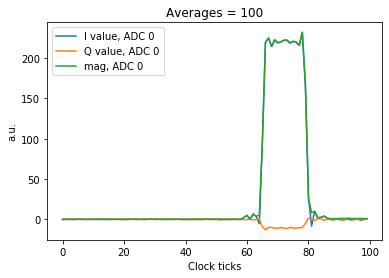

In [5]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

## Time of flight (tof) calibration

Find the mis-alignment between the DAC and ADC readout window for previous experiment

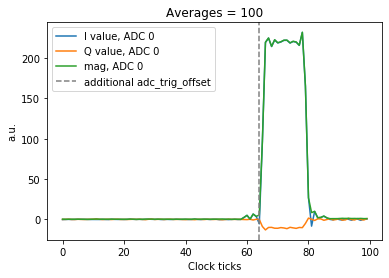

In [6]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

axvline(64, ls = '--', color = 'grey', label = 'additional adc_trig_offset') ### using this 'cursor' to find the additional adc_trig_offset
plt.legend()

Adjust the `adc_trig_offset` in the `config` dict

- The DAC and ADC has different fabric freq
    - DAC: fabric=430.080 MHz
    - ADC: fabric=307.200 MHz
- the readout plot data is sampled at ADC fabric freq, but the adc_trig_offset is used in DAC fabric freq
    - so we need to convert the measured delay into input delay:
    - input delay = meausured delay * DAC fabric freq/ADC fabric freq //1

In [7]:
64*430.080/307.2

89.6

Now, the time of flight is calibrated

  0%|          | 0/100 [00:00<?, ?it/s]

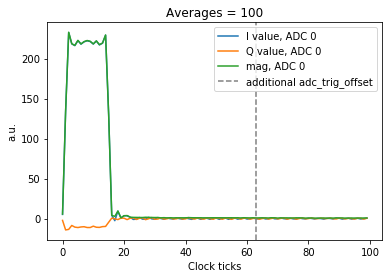

In [8]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks] ## pervious was 100
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)


###################
# plot the result
###################

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

axvline(63, ls = '--', color = 'grey', label = 'additional adc_trig_offset') ### using this 'cursor' to find the additional adc_trig_offset
plt.legend()

## Readout phase calibration
- code from qick_demos/05_PhaseCoherence_QickProgram.ipynb
- remeber to update the `adc_trig_offset` in the `config` file

In [9]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
        self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        
        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["ro_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             t=0,
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

### First, sanity check that we can see the pulse we want to calibrate

In [10]:
config={"res_ch":6, # --Fixed
        "ro_ch":0, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":400, # [Clock ticks] 
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 190, # [Clock ticks]
        "reps":1, 
        "soft_avgs":1,
       }

prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc,progress=False)

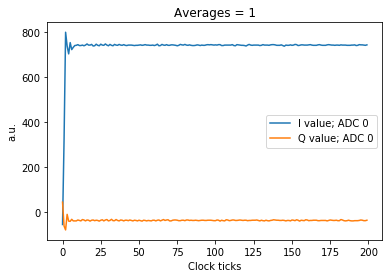

In [11]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### Params 3 (We zoom in on the frequency area of interest and then print out the associated phase of interest)

In [12]:
config={"res_ch":6, # --Fixed
        "ro_ch":0, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":400, # [Clock ticks] 
        "readout_length":200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 190, # [Clock ticks]
        "reps":1, 
        "soft_avgs":1,
       }


freq_readout = config["pulse_freq"]
freq_start = freq_readout - 0.002 ##[MHz]
freq_step = 0.000125  ##[MHz]
expts = 32

sweep_cfg={"start":freq_start, "step":freq_step, "expts":expts}

gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])
gpts

array([ 99.998   ,  99.998125,  99.99825 ,  99.998375,  99.9985  ,
        99.998625,  99.99875 ,  99.998875,  99.999   ,  99.999125,
        99.99925 ,  99.999375,  99.9995  ,  99.999625,  99.99975 ,
        99.999875, 100.      , 100.000125, 100.00025 , 100.000375,
       100.0005  , 100.000625, 100.00075 , 100.000875, 100.001   ,
       100.001125, 100.00125 , 100.001375, 100.0015  , 100.001625,
       100.00175 , 100.001875])

In [13]:
resultsi=[]
resultsq=[]
for g in gpts:
    time.sleep(0.1)
    config["pulse_freq"]=g
    prog =LoopbackProgram(soccfg, config)
    (iq0,) = prog.acquire_decimated(soc,progress=False)
    di0 = np.sum(iq0[0])/config["readout_length"]
    dq0 = np.sum(iq0[1])/config["readout_length"]
    resultsi.append(di0)
    resultsq.append(dq0)
resultsi=np.array(resultsi)
resultsq=np.array(resultsq)

Iteration i = 0, freq_i = 99.998000 MHz, phi_i = 240.661931 degrees
Iteration i = 1, freq_i = 99.998125 MHz, phi_i = 248.064686 degrees
Iteration i = 2, freq_i = 99.998250 MHz, phi_i = 255.054407 degrees
Iteration i = 3, freq_i = 99.998375 MHz, phi_i = 262.475027 degrees
Iteration i = 4, freq_i = 99.998500 MHz, phi_i = 269.521159 degrees
Iteration i = 5, freq_i = 99.998625 MHz, phi_i = 276.900674 degrees
Iteration i = 6, freq_i = 99.998750 MHz, phi_i = 284.411839 degrees
Iteration i = 7, freq_i = 99.998875 MHz, phi_i = 291.500362 degrees
Iteration i = 8, freq_i = 99.999000 MHz, phi_i = 299.004894 degrees
Iteration i = 9, freq_i = 99.999125 MHz, phi_i = 305.837968 degrees
Iteration i = 10, freq_i = 99.999250 MHz, phi_i = 313.311158 degrees
Iteration i = 11, freq_i = 99.999375 MHz, phi_i = 320.874569 degrees
Iteration i = 12, freq_i = 99.999500 MHz, phi_i = 327.910780 degrees
Iteration i = 13, freq_i = 99.999625 MHz, phi_i = 335.244938 degrees
Iteration i = 14, freq_i = 99.999750 MHz, ph

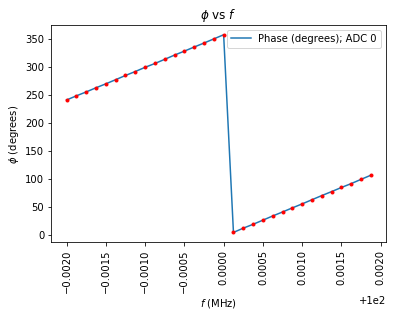

In [14]:
# Plot results.
sig = resultsi + 1j * resultsq
amp_array = np.abs(sig)
phase_array = np.angle(sig,deg=True)
for x in range(0,len(phase_array)):
    if phase_array[x] <0:
        phase_array[x] = phase_array[x] +360
    print("Iteration i = %d, freq_i = %f MHz, phi_i = %f degrees" %(x,gpts[x], phase_array[x]))
plt.figure(1)
# plt.plot(gpts, resultsi,label="I value; ADC 0")
# plt.plot(gpts, resultsq,label="Q value; ADC 0")
# plt.plot(gpts, amp_array,label="Amplitude (DAC units); ADC 0")
plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()
# plt.savefig("images/Phase_sweep.pdf", dpi=350)

At 100 MHz, Phase = 357.1809618238852 degree


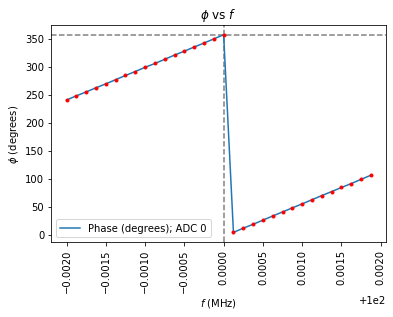

In [15]:
target_freq = freq_readout ### put the actual readout freq here

freq_index = np.where(gpts == target_freq)[0][0]
phase_cal = phase_array[freq_index]

print(f'At {target_freq} MHz, Phase = {phase_cal} degree')

plt.axvline(gpts[freq_index], ls = '--', color = 'grey')
plt.axhline(phase_array[freq_index], ls = '--', color = 'grey')


plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()

### re-run the loopback program with compensate phase
- Now the signal is only on I component

In [16]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [17]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": phase_cal, # updated readout phase
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/100 [00:00<?, ?it/s]

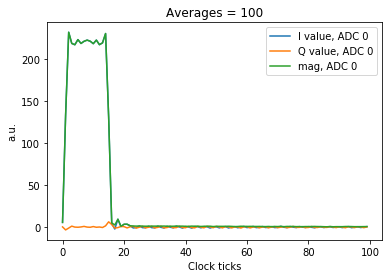

In [18]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

# Load real qubit readout data (old data from ZCU111)


g_data[p1,p2,p3] for ground state readout

e_data[p1,p2,p3] for excited state readout
- p1: index for shot
- p2: index for I/Q
- p3: index for time, step of clock cycle = 2.6ns

In [19]:
with open('readout_data.npy', 'rb') as f:
    g_data = np.load(f)
    e_data = np.load(f)

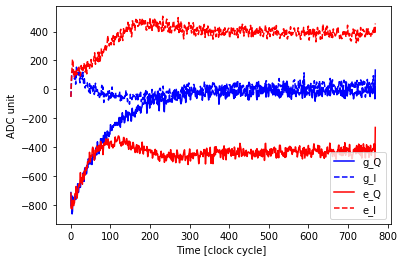

In [20]:
# avargaed trace
plt.plot(g_data[:,1,:].mean(axis = 0), label = 'g_Q', color = 'b')
plt.plot(g_data[:,0,:].mean(axis = 0), label = 'g_I', color = 'b', ls = '--')

plt.plot(e_data[:,1,:].mean(axis = 0), label = 'e_Q', color = 'r')
plt.plot(e_data[:,0,:].mean(axis = 0), label = 'e_I', color = 'r', ls = '--')

plt.ylabel('ADC unit')
plt.xlabel('Time [clock cycle] ')
plt.legend()

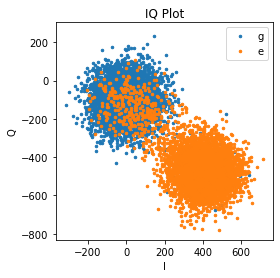

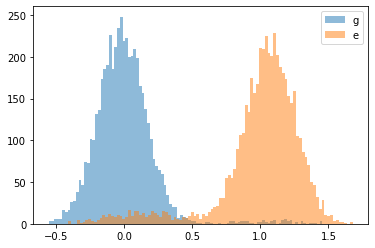

max fidelity =  0.9148000000000001

 rough estimation of n_th


1.74

In [21]:
# IQ plot
I_g = g_data[:,0,:].mean(axis = 1)
Q_g = g_data[:,1,:].mean(axis = 1)

I_e = e_data[:,0,:].mean(axis = 1)
Q_e = e_data[:,1,:].mean(axis = 1)

plt.title('IQ Plot')
plt.plot(I_g, Q_g, '.',label = 'g',markersize = 5)
plt.plot(I_e, Q_e, '.',label = 'e',markersize = 5)
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.axis('square')
plt.show()

vec_I = mean(I_e) - mean(I_g)
vec_Q = mean(Q_e) - mean(Q_g)

gstate = (I_g - mean(I_g))*vec_I + (Q_g - mean(Q_g))*vec_Q
estate = (I_e - mean(I_g))*vec_I + (Q_e - mean(Q_g))*vec_Q
gstate = gstate / abs(vec_I+1j*vec_Q)**2
estate = estate / abs(vec_I+1j*vec_Q)**2
plt.hist(gstate,bins = 100,label = 'g',alpha = 0.5)
plt.hist(estate,bins = 100,label = 'e',alpha = 0.5)
plt.legend()
plt.show()

th_min = min(gstate)
th_max = max(estate)
th_list = np.linspace(th_min,th_max,1000)

fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
print('max fidelity = ',max(fidelity)*2-1)

print('\n rough estimation of n_th')
100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)

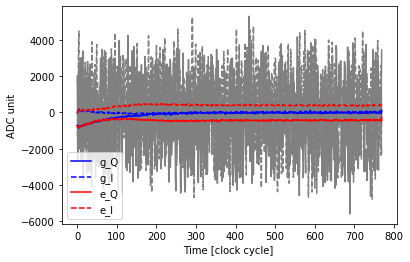

In [22]:
# signal shot
shot_index = 0

plt.plot(g_data[shot_index,1,:], color = 'grey')
plt.plot(g_data[shot_index,0,:], color = 'grey', ls = '--')

plt.plot(e_data[shot_index,1,:], color = 'grey')
plt.plot(e_data[shot_index,0,:], color = 'grey', ls = '--')

plt.plot(g_data[:,1,:].mean(axis = 0), label = 'g_Q', color = 'b')
plt.plot(g_data[:,0,:].mean(axis = 0), label = 'g_I', color = 'b', ls = '--')

plt.plot(e_data[:,1,:].mean(axis = 0), label = 'e_Q', color = 'r')
plt.plot(e_data[:,0,:].mean(axis = 0), label = 'e_I', color = 'r', ls = '--')

plt.ylabel('ADC unit')
plt.xlabel('Time [clock cycle] ')
plt.legend()
# xlim(0,100)

# readout mock - averaged signal (as an example)

- to get the wf for DAC, we need to resample the data due to 
    - the frequency on ADC and DAC are different
    - the wf need to sample in dds frequency

            DAC tile 3, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
            ADC tile 2, blk 0, 32-bit DDS, fabric=307.200 MHz, fs=2457.600 MHz

real readout data length = 770 clock cycle


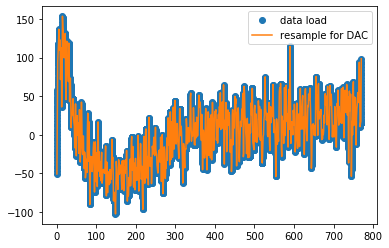

In [23]:
#### load real qubit readout data
data_len = len(g_data[:,0,:].mean(axis = 0))
print(f'real readout data length = {data_len} clock cycle')


### we need to resample the data based on DAC freq
t_ns = data_len*1000/307.2
dac_len = int((t_ns/1000*6881.28)//16*16)

g_I_load = g_data[:,0,:].mean(axis = 0)
g_Q_load = g_data[:,1,:].mean(axis = 0)
e_I_load = e_data[:,0,:].mean(axis = 0)
e_Q_load = e_data[:,1,:].mean(axis = 0)

### resample the waveform
xp = np.linspace(1,data_len,data_len) ### ADC side time array
x = np.linspace(1,data_len,dac_len)   ### DAC side time array

g_I = np.interp(x, xp, g_I_load)
g_Q = np.interp(x, xp, g_Q_load)
e_I = np.interp(x, xp, e_I_load)
e_Q = np.interp(x, xp, e_Q_load)


### plot one component of the resampled waveform
plot(x,g_I, 'o' , label = 'data load')
plot(xp,g_I_load, label = 'resample for DAC')
legend()
show()

In [24]:
DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]
        
        
        ########################
        ### add g/e waveform ###
        ########################
#         self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
#         self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
        self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
        self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
            
        ########################
        ### add g/e waveform ###
        ########################   
        elif style == "g_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
        elif style == "e_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")

        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [25]:
### calculate the DAC output range

gencfg = soccfg['gens'][6]
max_amp = gencfg['maxv']*gencfg['maxv_scale']
print('max_amp = ',max_amp)

max_amp =  32766.0


In [26]:
DAC_phase = -90
readout_phase = phase_cal + DAC_phase

config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": readout_phase, # updated readout phase
        "pulse_style": "e_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"
        
        "sigma": 30, # [Clock ticks]
        
        "length": 100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":data_len, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain": 30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

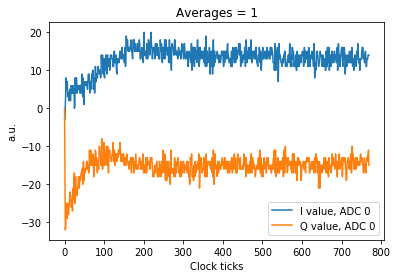

In [27]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

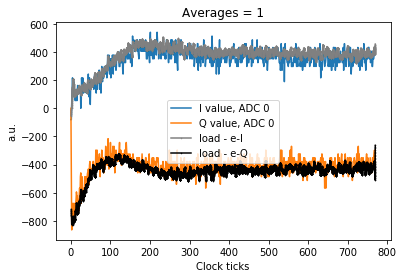

In [28]:
ADC_fake_gain = 27 ### tune this parameter to match the ADC level with the training data


for ii, iq in enumerate(iq_list):
    plt.plot(iq[0]*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1]*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value, ADC %d"%(config['ro_chs'][ii]))
plt.plot(x,e_I, '-o', markersize=0.5, color = 'grey', label = 'load - e-I')
plt.plot(x,e_Q, '-o', markersize=0.5, color = 'black', label = 'load - e-Q')


plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

# Readout mock - single-shot signal

## single-shot with tunable gaussian noise

readout data length = 770 clock cycle


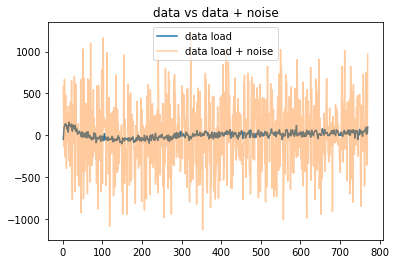

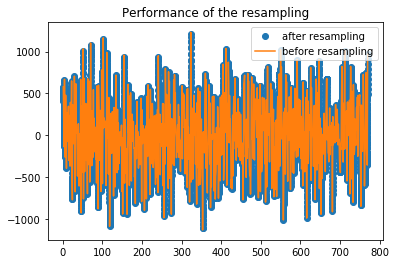

In [29]:
#### load real qubit readout data
data_len = len(g_data[:,0,:].mean(axis = 0))
print(f'readout data length = {data_len} clock cycle')


### we need to resample the data based on DAC freq
t_ns = data_len*1000/307.2
dac_len = int((t_ns/1000*6881.28)//16*16)

g_I_load = g_data[:,0,:].mean(axis = 0)
g_Q_load = g_data[:,1,:].mean(axis = 0)
e_I_load = e_data[:,0,:].mean(axis = 0)
e_Q_load = e_data[:,1,:].mean(axis = 0)

### set noise parameter
add_noise = True
noise_scale = 400

if add_noise == True:
    g_I_add_noise = g_I_load + np.random.normal(0, noise_scale, size = g_I_load.shape[0])
    g_Q_add_noise = g_Q_load + np.random.normal(0, noise_scale, size = g_Q_load.shape[0])
    e_I_add_noise = e_I_load + np.random.normal(0, noise_scale, size = e_I_load.shape[0])
    e_Q_add_noise = e_Q_load + np.random.normal(0, noise_scale, size = e_Q_load.shape[0])
    
plot(xp,g_I_load , label = 'data load')
plot(xp,g_I_add_noise, label = 'data load + noise', alpha = 0.4)
title('data vs data + noise')
legend()
show()
### resample the waveform
xp = np.linspace(1,data_len,data_len)
x = np.linspace(1,data_len,dac_len)
    
g_I = np.interp(x, xp, g_I_load)
g_Q = np.interp(x, xp, g_Q_load)
e_I = np.interp(x, xp, e_I_load)
e_Q = np.interp(x, xp, e_Q_load)

if add_noise == True:
    g_I = np.interp(x, xp, g_I_add_noise)
    g_Q = np.interp(x, xp, g_Q_add_noise)
    e_I = np.interp(x, xp, e_I_add_noise)
    e_Q = np.interp(x, xp, e_Q_add_noise)
    
    title('Performance of the resampling')
    plot(x, g_I, 'o', label = 'after resampling')
    plot(xp, g_I_add_noise, label = 'before resampling')
    legend()
    show()

In [30]:
DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]
        
        
        ########################
        ### add g/e waveform ###
        ########################
#         self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
#         self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
        self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
        self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
            
        ########################
        ### add g/e waveform ###
        ########################   
        elif style == "g_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
        elif style == "e_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")

        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [31]:
### calculate the DAC output range

gencfg = soccfg['gens'][6]
max_amp = gencfg['maxv']*gencfg['maxv_scale']
print('max_amp = ',max_amp)

max_amp =  32766.0


In [32]:
DAC_phase = -90
readout_phase = phase_cal + DAC_phase

config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": readout_phase, # updated readout phase
        "pulse_style": "e_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"
        
        "sigma": 30, # [Clock ticks]
        
        "length": 100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":data_len, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain": 30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

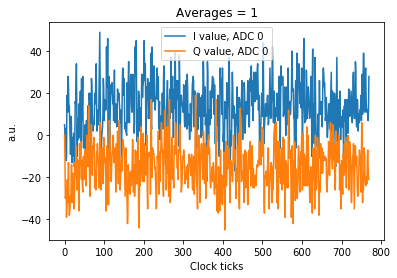

In [33]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

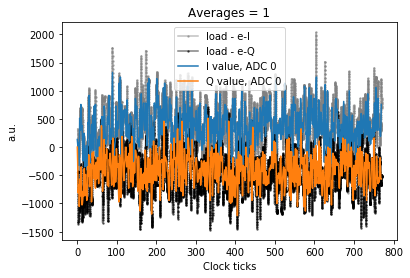

In [34]:
ADC_fake_gain = 27 ### tune this parameter to match the ADC level with the training data

plt.plot(x,e_I, '-o', markersize=1.5, color = 'grey', label = 'load - e-I', alpha = 0.5)
plt.plot(x,e_Q, '-o', markersize=1.5, color = 'black', label = 'load - e-Q', alpha = 0.5)

for ii, iq in enumerate(iq_list):
    plt.plot(iq[0]*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1]*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value, ADC %d"%(config['ro_chs'][ii]))


plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

## Average in python

In [35]:
N_exp = 200 ### iteration in python

data_tensor = np.zeros((N_exp, 2, data_len))

for ii in range(N_exp):
    #### load real qubit readout data
    data_len = len(g_data[:,0,:].mean(axis = 0))
    print(f'readout data length = {data_len} clock cycle')

    ### we need to resample the data based on DAC freq
    t_ns = data_len*1000/307.2
    dac_len = int((t_ns/1000*6881.28)//16*16)

    g_I_load = g_data[:,0,:].mean(axis = 0)
    g_Q_load = g_data[:,1,:].mean(axis = 0)
    e_I_load = e_data[:,0,:].mean(axis = 0)
    e_Q_load = e_data[:,1,:].mean(axis = 0)
    
    
    ### noise parameter
    add_noise = True
    noise_scale = 400

    if add_noise == True:
        g_I_add_noise = g_I_load + np.random.normal(0, noise_scale, size = g_I_load.shape[0])
        g_Q_add_noise = g_Q_load + np.random.normal(0, noise_scale, size = g_Q_load.shape[0])
        e_I_add_noise = e_I_load + np.random.normal(0, noise_scale, size = e_I_load.shape[0])
        e_Q_add_noise = e_Q_load + np.random.normal(0, noise_scale, size = e_Q_load.shape[0])
        
    xp = np.linspace(1,data_len,data_len)
    x = np.linspace(1,data_len,dac_len)
    
    ###################
    ##   interp wf   ##
    ###################
    
    g_I = np.interp(x, xp, g_I_load)
    g_Q = np.interp(x, xp, g_Q_load)
    e_I = np.interp(x, xp, e_I_load)
    e_Q = np.interp(x, xp, e_Q_load)

    if add_noise == True:
        g_I = np.interp(x, xp, g_I_add_noise)
        g_Q = np.interp(x, xp, g_Q_add_noise)
        e_I = np.interp(x, xp, e_I_add_noise)
        e_Q = np.interp(x, xp, e_Q_add_noise)
        
    ##########################
    ##   loopback porgram   ##
    ##########################
        
    DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

    class LoopbackProgram(AveragerProgram):
        def initialize(self):
            cfg=self.cfg   
            res_ch = cfg["res_ch"]

            # set the nyquist zone
            self.declare_gen(ch=cfg["res_ch"], nqz=1)

            # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
            for ch in cfg["ro_chs"]:
                self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                     freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

            # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
            freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
            phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
            gain = cfg["pulse_gain"]
            self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

            style=self.cfg["pulse_style"]


            ########################
            ### add g/e waveform ###
            ########################
    #         self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
    #         self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
            self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
            self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

            if style in ["flat_top","arb"]:
                sigma = cfg["sigma"]
                self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)

            if style == "const":
                self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
            elif style == "flat_top":
                # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
                self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
            elif style == "arb":
                self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")

            ########################
            ### add g/e waveform ###
            ########################   
            elif style == "g_state":
                self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
            elif style == "e_state":
                self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")


            self.synci(200)  # give processor some time to configure pulses

        def body(self):
            # fire the pulse
            # trigger all declared ADCs
            # pulse PMOD0_0 for a scope trigger
            # pause the tProc until readout is done
            # increment the time counter to give some time before the next measurement
            # (the syncdelay also lets the tProc get back ahead of the clock)
            self.measure(pulse_ch=self.cfg["res_ch"], 
                         adcs=self.ro_chs,
                         pins=[0], 
                         adc_trig_offset=self.cfg["adc_trig_offset"],
                         wait=True,
                         syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    ##########################
    ##   expt config        ##
    ##########################            
    DAC_phase = -90
    readout_phase = phase_cal + DAC_phase

    config={"res_ch":6, # --Fixed
            "ro_chs":[0], # --Fixed
            "reps":1, # --Fixed
            "relax_delay":1.0, # --us
            "res_phase": readout_phase, # updated readout phase
            "pulse_style": "e_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"

            "sigma": 30, # [Clock ticks]

            "length": 100, # [Clock ticks]
            # Try varying length from 10-100 clock ticks

            "readout_length":data_len, # [Clock ticks]
            # Try varying readout_length from 50-1000 clock ticks

            "pulse_gain": 30000, # [DAC units]
            # Try varying pulse_gain from 500 to 30000 DAC units

            "pulse_freq": 100, # [MHz]
            # In this program the signal is up and downconverted digitally so you won't see any frequency
            # components in the I/Q traces below. But since the signal gain depends on frequency, 
            # if you lower pulse_freq you will see an increased gain.

            "adc_trig_offset": 190, # [Clock ticks]
            # Try varying adc_trig_offset from 100 to 220 clock ticks

            "soft_avgs":1
            # Try varying soft_avgs from 1 to 200 averages

           }

    ###################
    # Try it yourself !
    ###################

    prog =LoopbackProgram(soccfg, config)
    iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)
    data_tensor[ii] = iq_list[0]


readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

readout data length = 770 clock cycle


  0%|          | 0/1 [00:00<?, ?it/s]

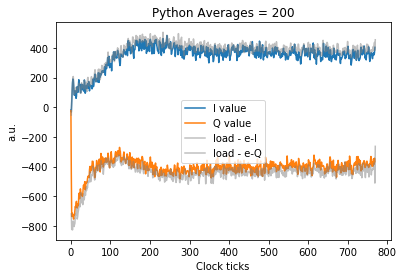

In [36]:
ADC_fake_gain = 27 ### tune this parameter to match the ADC level with the training data


plt.plot(data_tensor[:,0,:].mean(axis = 0)*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value")
plt.plot(data_tensor[:,1,:].mean(axis = 0)*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value")

plt.plot(xp, e_I_load, markersize=1.5, color = 'grey', label = 'load - e-I', alpha = 0.5)
plt.plot(xp, e_Q_load, markersize=1.5, color = 'grey', label = 'load - e-Q', alpha = 0.5)


plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Python Averages = " + str(N_exp))
plt.legend()